In [32]:
import os
import sys
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from dejavuoob.utils.image_common import ImageFolderIndexWithPath, SSL_Transform

from torch.utils.data import DataLoader
from IPython.display import clear_output



In [33]:
def get_confidence_and_topk(neighb_labels, k_neighbs = 100, topk = [1]):
    from scipy.stats import entropy
    import torch

    #get class counts
    class_cts = np.apply_along_axis(np.bincount, axis=1,
                            arr=neighb_labels[:,:k_neighbs], minlength=1000)
    #get confidence
    attk_uncert = entropy(class_cts, axis = 1)
    preds = {}
    preds_values = {}
    for k in topk:
        topk_cts, topk_preds = torch.topk(torch.Tensor(class_cts), k, dim = 1)
        topk_preds = np.array(topk_preds).astype(int)
        preds[f'top_{k}'] = topk_preds
        preds_values[f'top[k]'] = topk_cts

    return -attk_uncert, preds

In [34]:

VICREG_KNN_ROOT_PATH_MEM_OOB = '<PATH-TO-VICREG-OUTPUT>/dejavu/vicreg/attack_sweeps/NN_attk_vicregoob_bbox_B_bbox_A_blurred_05.10.2024'

vicreg_bbox_attk_B_idxs_mem_oob = np.load(VICREG_KNN_ROOT_PATH_MEM_OOB + '/test_attk_A_attk_idxs.npy')
vicreg_bbox_attk_B_labels_mem_oob = np.load(VICREG_KNN_ROOT_PATH_MEM_OOB + '/test_attk_A_labels.npy')
vicreg_bbox_attk_B_neighb_labels_mem_oob = np.load(VICREG_KNN_ROOT_PATH_MEM_OOB + '/test_attk_A_neighb_labels.npy')
vicreg_bbox_attk_B_neighb_idx_mem_oob = np.load(VICREG_KNN_ROOT_PATH_MEM_OOB + '/test_attk_A_neighb_idxs.npy')

len(vicreg_bbox_attk_B_labels_mem_oob)

139183

In [35]:
# test on memorization for set B OOB

vicreg_confidences_mem_oob, vicreg_pred_idxes_mem_oob = get_confidence_and_topk(vicreg_bbox_attk_B_neighb_labels_mem_oob)

vicreg_confidences_mem_oob, vicreg_pred_idxes_mem_oob = vicreg_confidences_mem_oob, vicreg_pred_idxes_mem_oob['top_1']

len(vicreg_confidences_mem_oob)

139183

In [36]:
#sorted(vicreg_confidences_mem_oob)[::-1]

In [37]:
# load dataset mem oob
img_dir = '<PATH-TO-IMAGENET-TRAIN>/train_blurred'
vicreg_dataset = ImageFolderIndexWithPath(img_dir, SSL_Transform(), vicreg_bbox_attk_B_idxs_mem_oob)
vicreg_dataloader_mem_oob = DataLoader(vicreg_dataset, batch_size = 1, shuffle = False, num_workers=8)

In [38]:
predictions_to_save = []
for (x, y, idx, path), label, confidence, pred in zip(vicreg_dataloader_mem_oob, vicreg_bbox_attk_B_labels_mem_oob, vicreg_confidences_mem_oob, vicreg_pred_idxes_mem_oob):
    predictions_to_save.append([label[0], pred[0], confidence, path[0]])
    
columns = ['label_vmo', 'pred_vmo', 'conf_vmo', 'path_vmo']

vicreg_predictions_knn_mem_oob = pd.DataFrame.from_records(np.array(predictions_to_save), columns=columns)

vicreg_predictions_knn_mem_oob['path_vmo'] = vicreg_predictions_knn_mem_oob['path_vmo'].str.split('/').str[-1].str.split('.').str[0]
vicreg_predictions_knn_mem_oob = vicreg_predictions_knn_mem_oob.sort_values(by = ['path_vmo'], ascending=True)


<H2>Resnet starts here</H2>

In [39]:
# resnet experiments go here

predictions_resnet = np.load('<PATH-TO-RESNET-OUTPUT>/dejavu/resnet50_crops/eval/supervised_train_A_test_B_set_07_15_2024_wd_0.1_lars_mom_0.9_w_aug_eval3.npy')

columns = ['label', 'pred', 'conf', 'y_conf', 'entropy', 'path']

predictions_resnet = pd.DataFrame.from_records(np.array(predictions_resnet), columns=columns)
predictions_resnet['path'] = predictions_resnet['path'].str.split('/').str[-1].str.split('.').str[0]
predictions_resnet_srt = predictions_resnet.sort_values(by = ['path'], ascending=True)


In [40]:
#sorted(list(predictions_resnet_srt['entropy']))

In [41]:
result_res = pd.merge(vicreg_predictions_knn_mem_oob, predictions_resnet, how="inner", left_on = 'path_vmo', right_on='path')

cond1 = result_res['pred_vmo'] == result_res['label_vmo']
result_res = result_res[cond1]

cond1 = result_res['pred'] != result_res['label']
result_res = result_res[cond1]

result_res['conf_vmo'] = result_res['conf_vmo'].astype(np.float64)

result_res['y_conf'] = result_res['y_conf'].astype(np.float64)

result_res['entropy'] = result_res['entropy'].astype(np.float64)

In [42]:
result_res['mem_final'] = result_res['entropy'] - result_res['conf_vmo'] * -1



In [43]:
#result_res.sort_values(by=['mem_final']).head(50)

In [44]:
result_res_sorted = result_res.sort_values(by=['mem_final'], ascending=False)


In [45]:
#result_res_sorted[result_res_sorted['mem_final'] >= 0.0]

In [46]:
#mem_scores = list(filter(lambda x: x > 0.1, np.clip(list(result_res['conf_vmo_exp'] - result_res['y_conf']), 0.0, 1.0)))

mem_scores = list(result_res_sorted['mem_final'])#list(result_res_sorted[result_res_sorted['mem_final'] >= 0.0]['mem_final'])
#mem_scores

In [47]:
import matplotlib

matplotlib.__version__

'3.8.0'

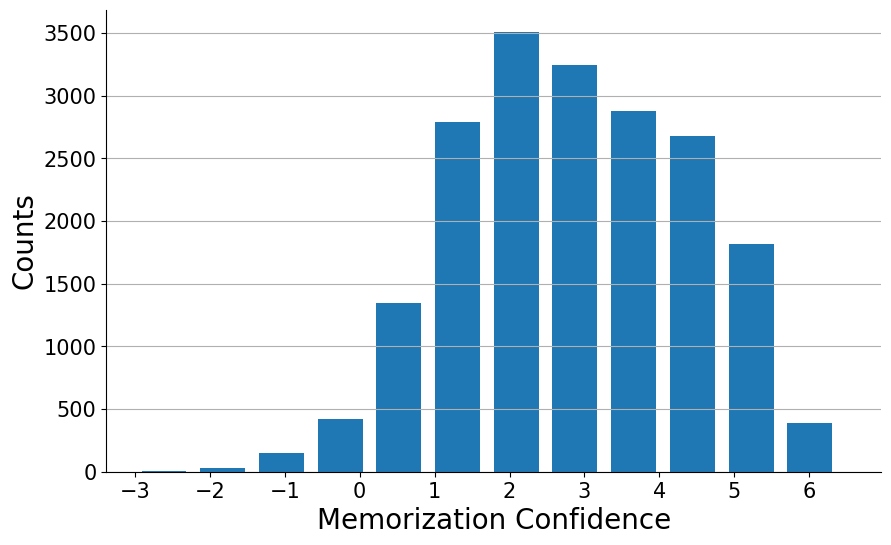

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(mem_scores, 12, density=False, width=0.6, align = 'mid')  # density=False would make counts

plt.ylabel('Counts', fontsize = 20)
plt.xlabel('Memorization Confidence', fontsize = 20)

plt.xticks(np.arange(-3.0, 7.0), fontsize = 15)
plt.yticks(fontsize = 15)

plt.grid(axis='y')

for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 
    
plt.show()